In [1]:
#Import packages
using Pkg
using DifferentialEquations, RecursiveArrayTools, Plots, DiffEqParamEstim
using Optimization, ForwardDiff, OptimizationOptimJL, OptimizationBBO, CSV, DataFrames, Statistics

In [5]:
] status

Status `~/.julia/environments/v1.9/Project.toml`
⌃ [336ed68f] CSV v0.10.12
  [a93c6f00] DataFrames v1.6.1
⌃ [1130ab10] DiffEqParamEstim v2.1.0
⌃ [0c46a032] DifferentialEquations v7.11.0
  [f6369f11] ForwardDiff v0.10.36
  [7073ff75] IJulia v1.24.2
⌃ [429524aa] Optim v1.7.8
⌃ [7f7a1694] Optimization v3.19.3
⌃ [3e6eede4] OptimizationBBO v0.1.5
⌃ [36348300] OptimizationOptimJL v0.1.14
  [06bb1623] PenaltyFunctions v0.3.0
⌅ [91a5bcdd] Plots v1.39.0
⌅ [731186ca] RecursiveArrayTools v2.38.10
  [2913bbd2] StatsBase v0.34.2
  [10745b16] Statistics v1.9.0
Info Packages marked with ⌃ and ⌅ have new versions available, but those with ⌅ are restricted by compatibility constraints from upgrading. To see why use `status --outdated`


In [ ]:
#create results directory
resultsdirectory = "/results/"
mkpath(resultsdirectory)

In [ ]:
#Calculate for growth rates for logistic growth model for all the conditions (glu+ and glu-, 0 and 50 cis)

#Normalize values of growth against the glu+ and 0 cis since that is the "standard" conditions for cellular growth 

## No treatment 

OVCAR3 sensitive

In [180]:
###NO TREATMENT

##OVCA3 sensitive
#glut +
OVCAR3_S_glu1="/data/OVCAR3_S_Glu+_0cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  2.09752  3.72623  6.29618  9.51651  12.4525  13.4473  14.0407

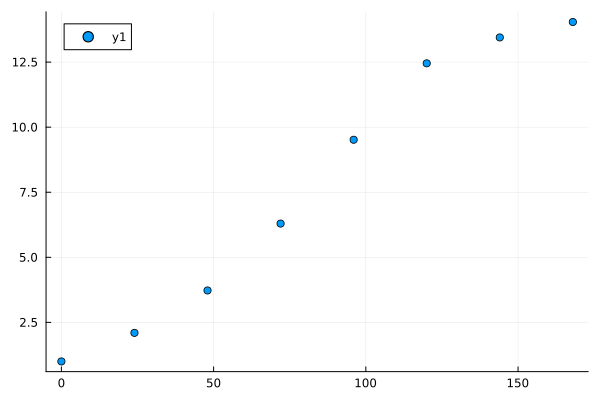

In [182]:
timepts = [0.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0]
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [4]:
#stop at the hour 168 and we have 8 datapoints within those time points 
t= collect(range(0, stop=168, length = 8))

8-element Vector{Float64}:
   0.0
  24.0
  48.0
  72.0
  96.0
 120.0
 144.0
 168.0

In [9]:
# generalized logistic growth of a single population with carrying capacity
# p1 is the growth rate, p2 is the carrying capacity, p3 is the shape of the curve and p4 is the effect of glutamine on the population
function singleLogGrowth(du,u,p,t)
    du[1] = p[1].*u[1].*(1-(abs(u[1]./p[2])))
end

u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 15.0]

2-element Vector{Float64}:
  0.09
 15.0

In [185]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [186]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Vector{Float64}:
   0.0
   0.16414624726773652
   1.7952631388785134
   5.126722193627398
   9.411934377251775
  14.789761527510619
  21.397948410097403
  29.69946317251464
  40.988425536746114
  50.80849918547477
  64.69636377378416
  75.45131257355374
  90.09848277193673
 104.97503882045163
 124.20028060078434
 146.48294057959868
 168.0
u: 17-element Vector{Vector{Float64}}:
 [1.0]
 [1.0138768679864723]
 [1.1617771816939726]
 [1.5266301806968716]
 [2.1424462997578613]
 [3.192379690234981]
 [4.933246005024715]
 [7.627100192290818]
 [11.1114555317847]
 [13.104950259589065]
 [14.402519141124824]
 [14.767226964466436]
 [14.936681446322824]
 [14.983252331516411]
 [14.996880888609107]
 [14.999506614618745]
 [14.999919702315687]

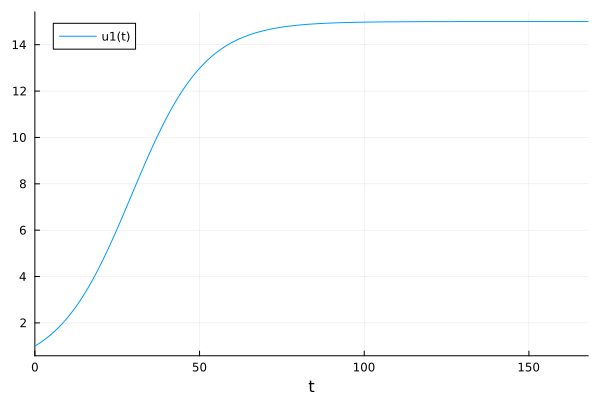

In [187]:
#plot(sol)

In [188]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [190]:
optprob = Optimization.OptimizationProblem(cost_function, [0.09,15.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
  0.033280724664674036
 15.036158674072555

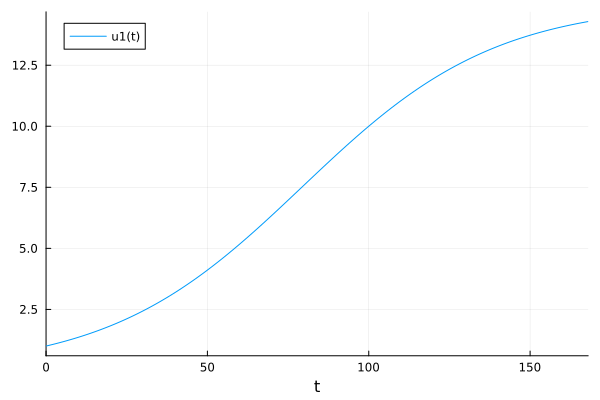

In [191]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

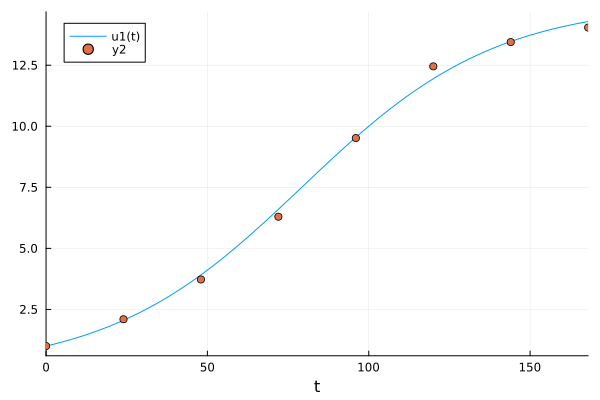

In [192]:
#scatter!(timepts,data_plot)

In [36]:
newsol.u

169-element Vector{Vector{Float64}}:
 [1320.8]
 [1362.4305102071162]
 [1405.273716144029]
 [1449.3585940357984]
 [1494.714440355438]
 [1541.3708459803213]
 [1589.357586471859]
 [1638.7046199366384]
 [1689.4420870264248]
 [1741.6003109381595]
 [1795.209614628111]
 [1850.3004103438386]
 [1906.9034895140446]
 ⋮
 [18465.281201009453]
 [18507.820616080746]
 [18549.154441449245]
 [18589.311099947332]
 [18628.31870437868]
 [18666.20505751827]
 [18702.99765211239]
 [18738.72367087863]
 [18773.40998650589]
 [18807.083161654366]
 [18839.76944895557]
 [18871.494791012305]

In [193]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_S_Glu+_0cis_norm.csv",newsol)

"Predicted_OVCAR3_S_Glu+_0cis_norm.csv"

In [195]:
#glu -
OVCAR3_S_glu1="/data/OVCAR3_S_Glu-_0cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.97825  3.34257  3.76382  3.92783  4.073  4.17288  4.5836

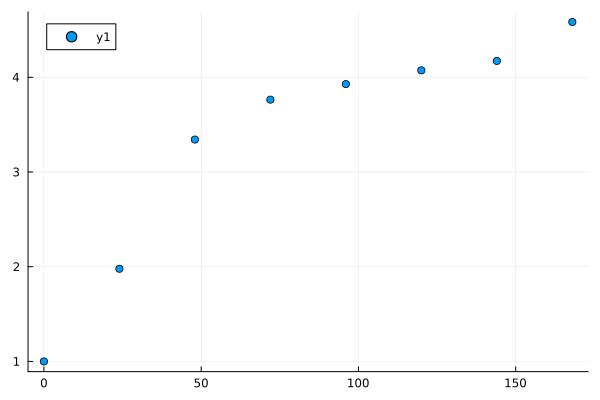

In [196]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [197]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.02, 5.0]

2-element Vector{Float64}:
 0.02
 5.0

In [198]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [199]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 9-element Vector{Float64}:
   0.0
   0.22869823818762144
   2.5156806200638355
  15.03676510653283
  36.77077014341569
  65.83082157959001
 102.85449985761585
 140.53410063704098
 168.0
u: 9-element Vector{Vector{Float64}}:
 [1.0]
 [1.0036641933901778]
 [1.0408590000431215]
 [1.2622772951341645]
 [1.7139575277562253]
 [2.412938274612652]
 [3.3084112855496906]
 [4.030130737915233]
 [4.390045629560663]

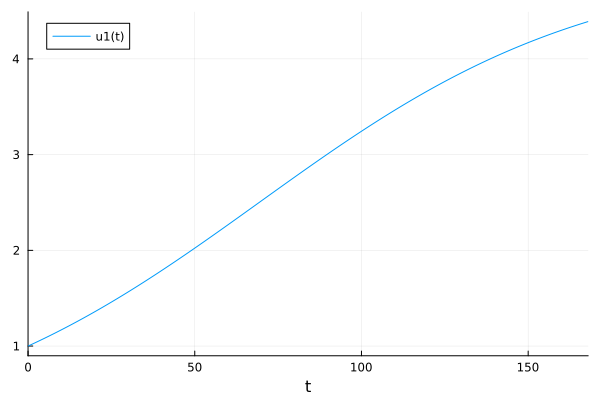

In [200]:
#plot(sol)

In [201]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [214]:
optprob = Optimization.OptimizationProblem(cost_function, [0.5,6.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.04669976045045326
 4.256510658000165

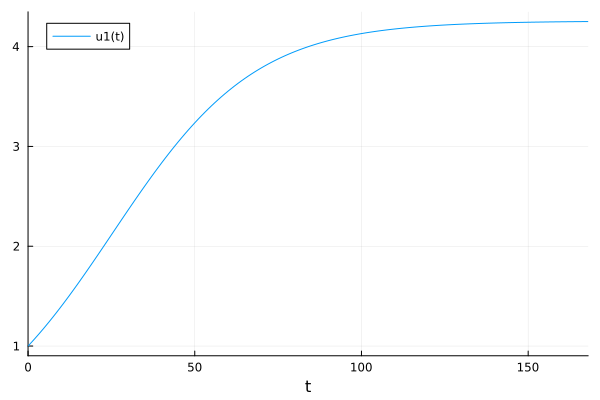

In [208]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

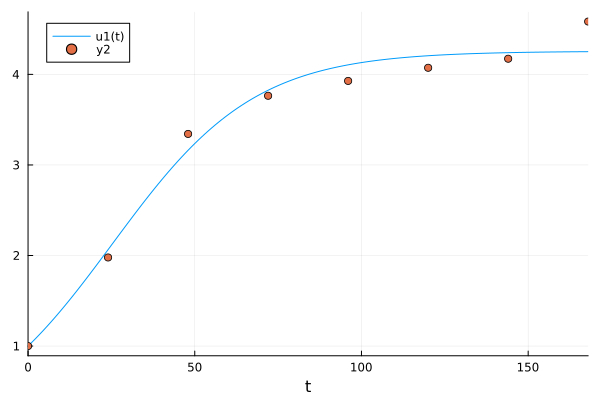

In [209]:
#scatter!(timepts,data_plot)

In [88]:
#newsol

retcode: Success
Interpolation: 1st order linear
t: 169-element Vector{Float64}:
   0.0
   1.0
   2.0
   3.0
   4.0
   5.0
   6.0
   7.0
   8.0
   9.0
  10.0
  11.0
  12.0
   ⋮
 157.0
 158.0
 159.0
 160.0
 161.0
 162.0
 163.0
 164.0
 165.0
 166.0
 167.0
 168.0
u: 169-element Vector{Vector{Float64}}:
 [1443.8]
 [1496.0215826398837]
 [1549.509512742757]
 [1604.2499746000412]
 [1660.2257506408966]
 [1717.4160589585138]
 [1775.7964445122468]
 [1835.3387782612333]
 [1896.0112571643922]
 [1957.7784041804262]
 [2020.6014735425263]
 [2084.438240414567]
 [2149.2408246052473]
 ⋮
 [6132.501996003666]
 [6133.085440752879]
 [6133.641165269158]
 [6134.170869903947]
 [6134.676248952764]
 [6135.158990655184]
 [6135.62077719486]
 [6136.063284699505]
 [6136.488183240902]
 [6136.897136834902]
 [6137.2909901369985]
 [6137.667337129516]

In [210]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_S_Glu-_0cis_norm.csv",newsol)

"Predicted_OVCAR3_S_Glu-_0cis_norm.csv"

OVCAR3 persistent

In [211]:
##OVCA3 persistent
#glu +
OVCAR3_S_glu1="/data/OVCAR3_R_Glu+_0cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.85494  2.91698  4.2876  5.30889  5.89701  5.98507  5.80795

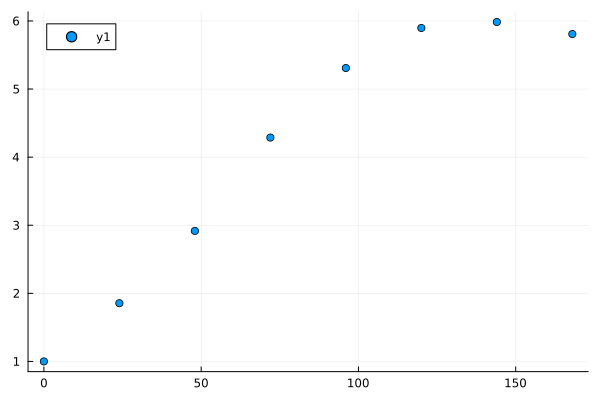

In [212]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [213]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 6.0]

2-element Vector{Float64}:
 0.09
 6.0

In [215]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [216]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 16-element Vector{Float64}:
   0.0
   0.16790922720817608
   1.8470014992899368
   5.66845955440669
  10.867380425641397
  17.9647053477732
  26.63421136226603
  35.514620270776575
  49.319441992009445
  59.05863698215297
  72.71354682305686
  86.20430473823934
 103.69826020682844
 123.58189573280073
 149.50019118234633
 168.0
u: 16-element Vector{Vector{Float64}}:
 [1.0]
 [1.0126567065108567]
 [1.1462945838176444]
 [1.4992528488685473]
 [2.0831948998541]
 [3.0110793696514517]
 [4.123956054263509]
 [4.981064124044921]
 [5.665237135107986]
 [5.855958574236809]
 [5.957015363421758]
 [5.987137549554505]
 [5.997271075126618]
 [5.99951397786914]
 [5.9999214256662246]
 [5.999984605344333]

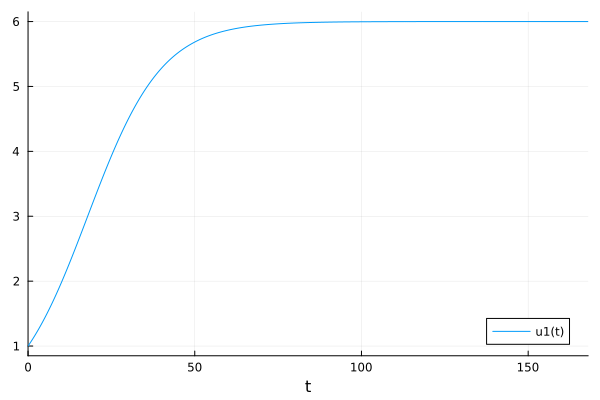

In [217]:
#plot(sol)

In [218]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [219]:
optprob = Optimization.OptimizationProblem(cost_function, [0.09,6.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.03457354789623479
 6.154041919322154

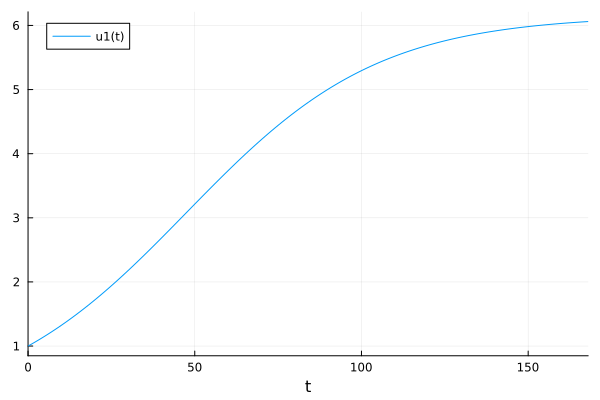

In [220]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

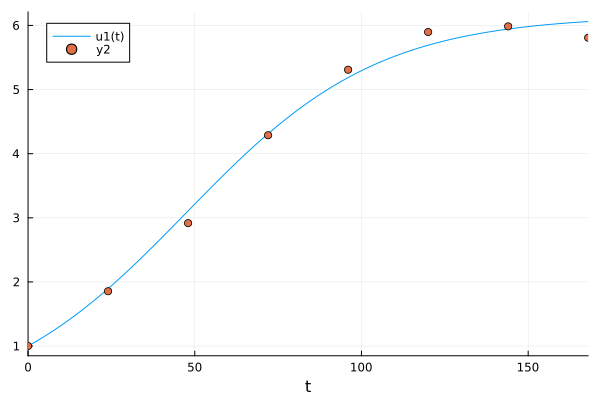

In [221]:
#scatter!(timepts,data_plot)

In [222]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_R_Glu+_0cis_norm.csv",newsol)

"Predicted_OVCAR3_R_Glu+_0cis_norm.csv"

In [223]:
#glu -
OVCAR3_S_glu1="/data/OVCAR3_R_Glu-_0cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.68837  2.34585  2.56742  2.61543  2.78426  2.85829  2.87809

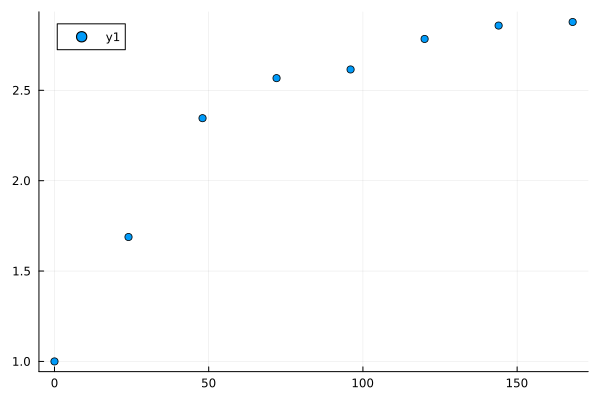

In [224]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [225]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 4.0]

2-element Vector{Float64}:
 0.09
 4.0

In [226]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [227]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 15-element Vector{Float64}:
   0.0
   0.17148496965598153
   1.8863346662157967
   6.559857901528284
  14.044780779096861
  21.40100507757819
  30.399643363899937
  44.72268936802675
  53.94690798343294
  67.85285953538086
  81.08969254659571
  98.76387378179433
 118.55321949762948
 144.69246295546571
 168.0
u: 15-element Vector{Vector{Float64}}:
 [1.0]
 [1.0116198389251672]
 [1.1326386896734355]
 [1.502438837207158]
 [2.1650429635998263]
 [2.7832881198238284]
 [3.3487006868277684]
 [3.7963444606055115]
 [3.9085811878242542]
 [3.9733340720231958]
 [3.991842409942795]
 [3.998293873060364]
 [3.999694316192024]
 [3.9999500146114797]
 [3.999992282474429]

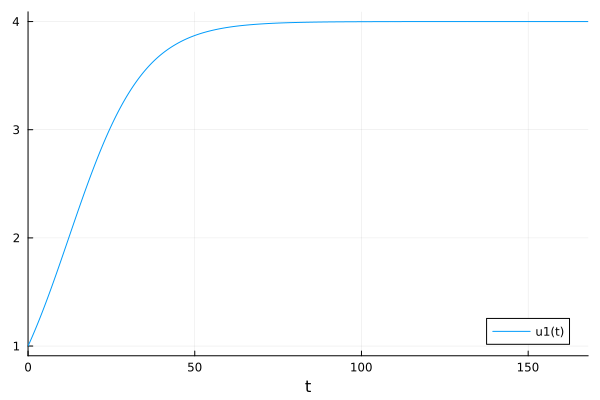

In [228]:
#plot(sol)

In [229]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [231]:
optprob = Optimization.OptimizationProblem(cost_function, [0.02,4.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.04219048897760937
 2.823464645385202

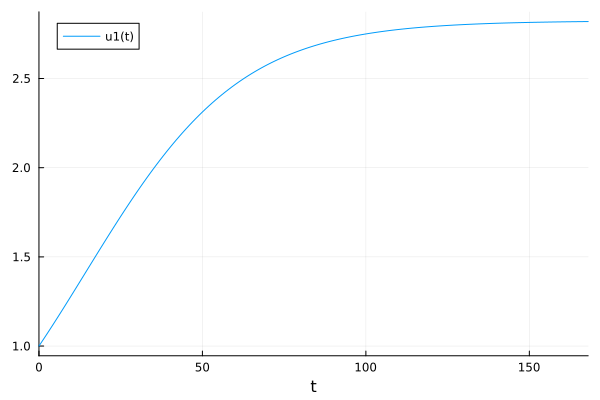

In [232]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

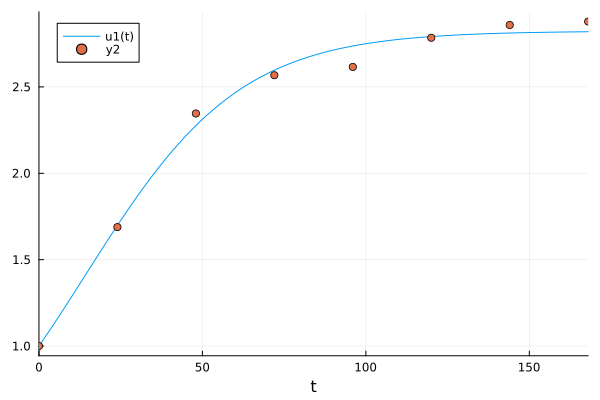

In [233]:
#scatter!(timepts,data_plot)

In [234]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_R_Glu-_0cis_norm.csv",newsol)

"Predicted_OVCAR3_R_Glu-_0cis_norm.csv"

## With treatment

OVCAR3 sensitive

In [235]:
###WITH TREATMENT

##OVCA3 sensitive
#glu +
OVCAR3_S_glu1="/data/OVCAR3_S_Glu+_50cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.90286  3.14751  4.29454  5.57156  7.14547  8.14266  8.54012

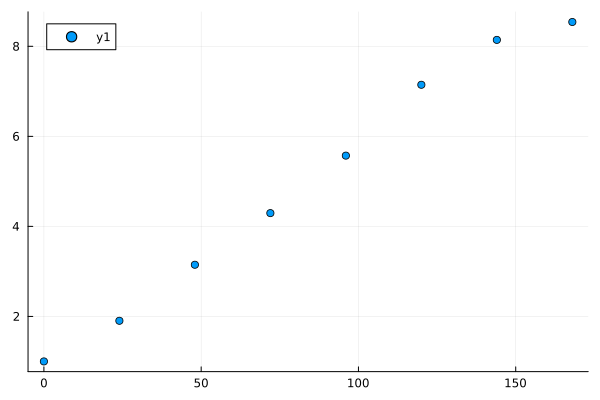

In [236]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [237]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 10.0]

2-element Vector{Float64}:
  0.09
 10.0

In [238]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [239]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 17-element Vector{Float64}:
   0.0
   0.16534452229141533
   1.8187897452055686
   5.292476187744985
   9.827089731374674
  15.596426367280756
  22.991835470313134
  35.088500334430876
  43.85846733110678
  59.16106300631232
  68.97874979370938
  83.93879467595681
  98.05619548429624
 117.14385127799639
 138.5295739617927
 167.16992500940844
 168.0
u: 17-element Vector{Vector{Float64}}:
 [1.0]
 [1.0134728535336908]
 [1.1572683311969365]
 [1.5175505480829876]
 [2.1202095029428243]
 [3.114078070305544]
 [4.680539638555271]
 [7.232821582918973]
 [8.519650668275009]
 [9.57895326497386]
 [9.82155348984241]
 [9.952674636257532]
 [9.986620897484512]
 [9.997483568575474]
 [9.999587710742235]
 [9.999916851922244]
 [9.999922837241561]

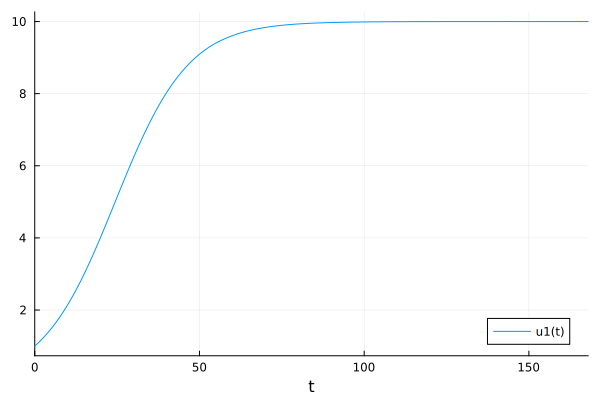

In [240]:
#plot(sol)

In [241]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [242]:
optprob = Optimization.OptimizationProblem(cost_function, [0.09,10.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.02735121271311404
 9.316688553005791

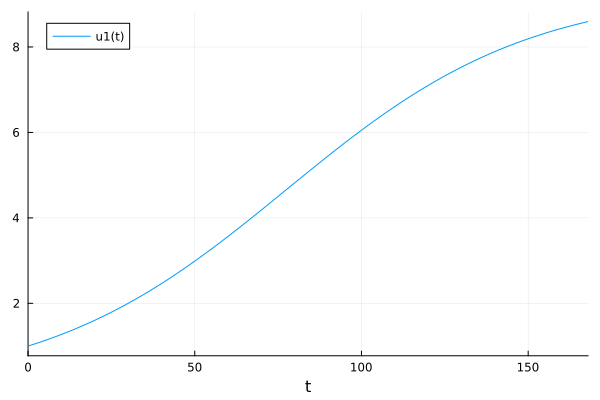

In [243]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

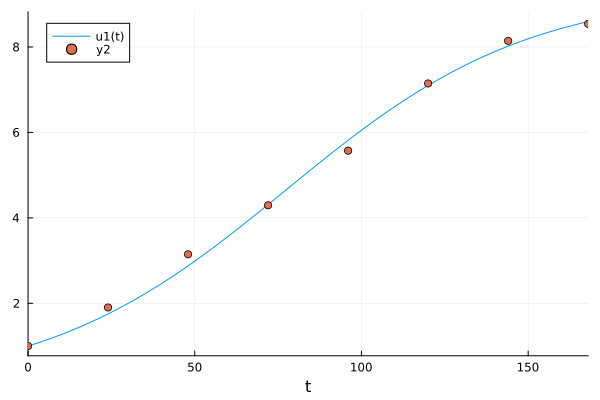

In [244]:
#scatter!(timepts,data_plot)

In [245]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_S_Glu+_50cis_norm.csv",newsol)

"Predicted_OVCAR3_S_Glu+_50cis_norm.csv"

In [246]:
#glu -
OVCAR3_S_glu1="/data/OVCAR3_S_Glu-_50cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.60227  1.95634  2.10698  2.36066  2.45262  2.60227  2.85568

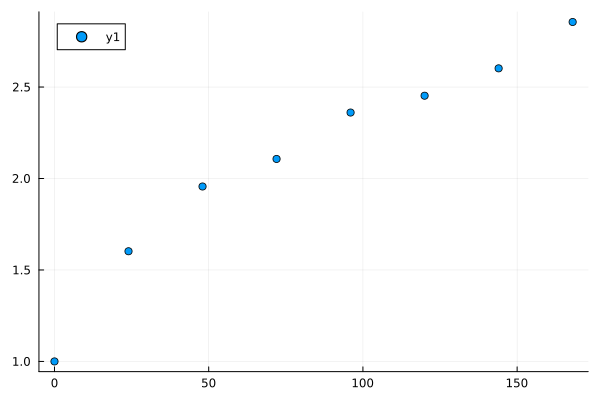

In [247]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [248]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 4.0]

2-element Vector{Float64}:
 0.09
 4.0

In [249]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [250]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 15-element Vector{Float64}:
   0.0
   0.17148496965598153
   1.8863346662157967
   6.559857901528284
  14.044780779096861
  21.40100507757819
  30.399643363899937
  44.72268936802675
  53.94690798343294
  67.85285953538086
  81.08969254659571
  98.76387378179433
 118.55321949762948
 144.69246295546571
 168.0
u: 15-element Vector{Vector{Float64}}:
 [1.0]
 [1.0116198389251672]
 [1.1326386896734355]
 [1.502438837207158]
 [2.1650429635998263]
 [2.7832881198238284]
 [3.3487006868277684]
 [3.7963444606055115]
 [3.9085811878242542]
 [3.9733340720231958]
 [3.991842409942795]
 [3.998293873060364]
 [3.999694316192024]
 [3.9999500146114797]
 [3.999992282474429]

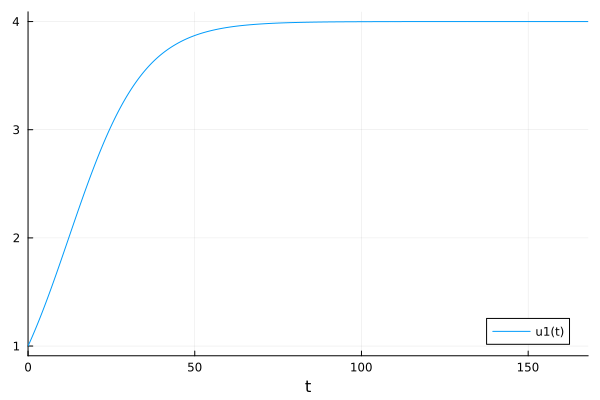

In [251]:
#plot(sol)

In [252]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [254]:
optprob = Optimization.OptimizationProblem(cost_function, [0.02,4.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.02716116056589396
 2.731666630528944

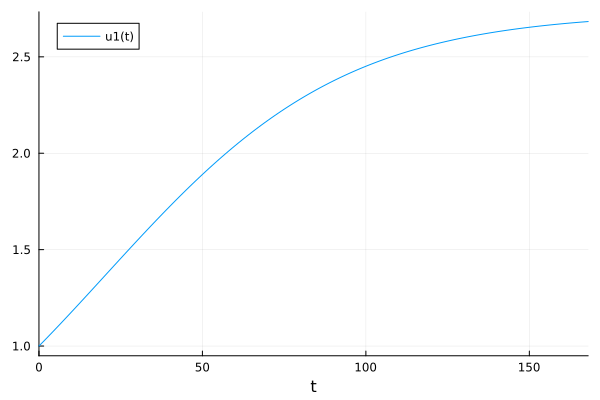

In [255]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

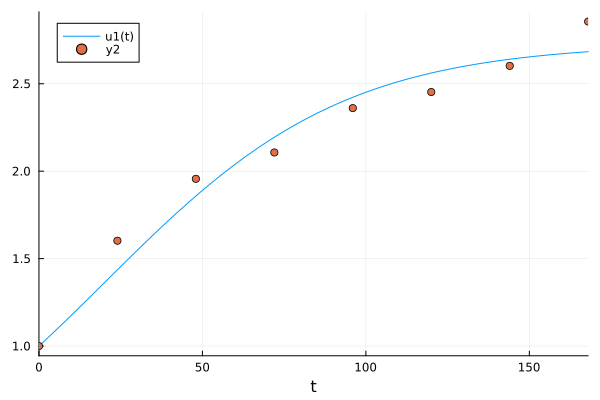

In [256]:
#scatter!(timepts,data_plot)

In [257]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_S_Glu-_50cis_norm.csv",newsol)

"Predicted_OVCAR3_S_Glu-_50cis_norm.csv"

OVCAR3 persistent

In [258]:
##OVCA3 persistent
#glu +
OVCAR3_S_glu1="/data/OVCAR3_R_Glu+_50cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.71095  2.49961  3.26738  3.99632  4.75726  5.17432  5.30182

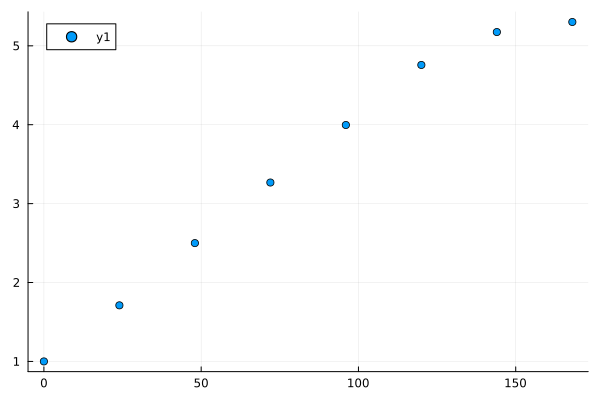

In [259]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [260]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 7.0]

2-element Vector{Float64}:
 0.09
 7.0

In [261]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [262]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 16-element Vector{Float64}:
   0.0
   0.16696585722342405
   1.8366244294576646
   5.51818731595173
  10.442801839501666
  16.908123429329134
  28.98187078392686
  37.018417212441875
  53.00522542359312
  62.25463011633818
  76.99124848635438
  90.44985975915564
 108.91903055643873
 129.26140678303284
 156.54640354305965
 168.0
u: 16-element Vector{Vector{Float64}}:
 [1.0]
 [1.0129494763248743]
 [1.1502080375114234]
 [1.5049091470347689]
 [2.093230516178781]
 [3.0303015438299874]
 [4.854688082847532]
 [5.764201230431383]
 [6.660245640226563]
 [6.848034866707918]
 [6.958797645133267]
 [6.987646705816937]
 [6.997569303418442]
 [6.999579170365863]
 [6.9999255761351]
 [6.999973431836639]

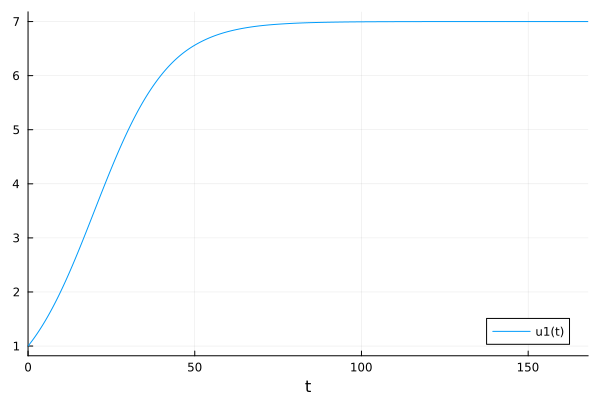

In [263]:
#plot(sol)

In [264]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [265]:
optprob = Optimization.OptimizationProblem(cost_function, [0.09,7.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.02608993463639369
 5.661097221358466

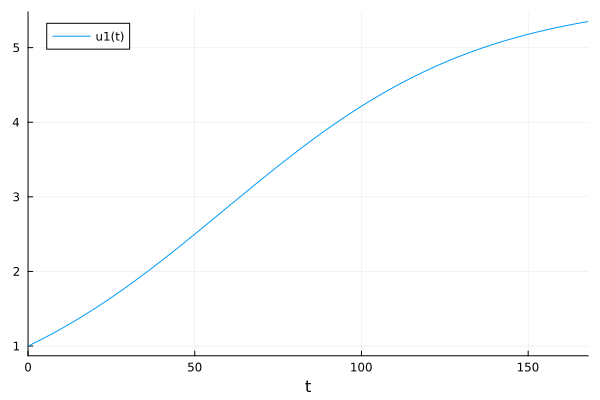

In [266]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

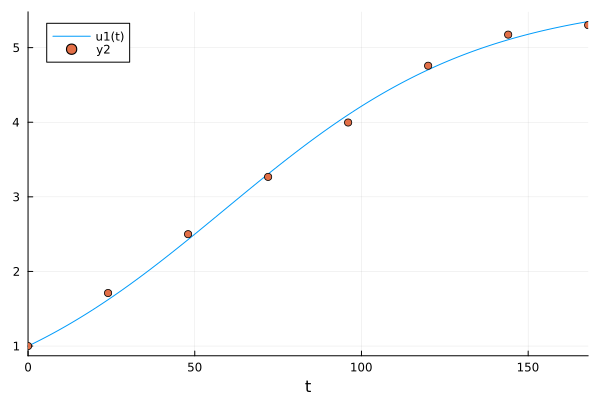

In [267]:
#scatter!(timepts,data_plot)

In [268]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_R_Glu+_50cis_norm.csv",newsol)

"Predicted_OVCAR3_R_Glu+_50cis_norm.csv"

In [3]:
#glu - 
OVCAR3_S_glu1="/data/OVCAR3_R_Glu-_50cis_avg_norm.csv"
OVCAR3_S_glu=CSV.read(OVCAR3_S_glu1,DataFrame)
data=Matrix(OVCAR3_S_glu)

1×8 Matrix{Float64}:
 1.0  1.49956  1.91398  2.20001  2.34654  2.67418  2.8721  2.96834

In [5]:
timepts = [0.0, 24.0, 48.0, 72.0, 96.0, 120.0, 144.0, 168.0]

8-element Vector{Float64}:
   0.0
  24.0
  48.0
  72.0
  96.0
 120.0
 144.0
 168.0

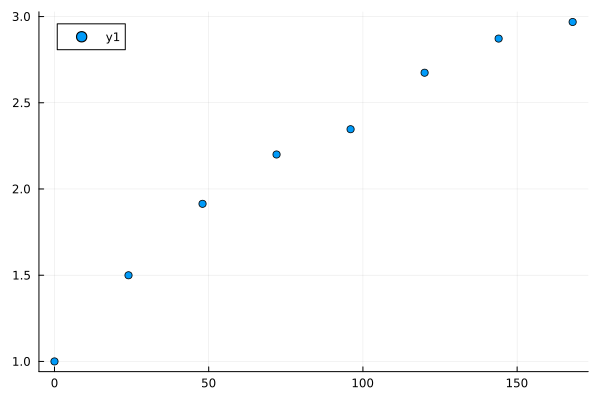

In [6]:
#data_plot= data[1,:]
#scatter(timepts,data_plot)

In [10]:
u0=[1.0]
tspan=(0.0,168.0)
p=[0.09, 4.0]

2-element Vector{Float64}:
 0.09
 4.0

In [11]:
prob=ODEProblem(singleLogGrowth,u0,tspan,p)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 168.0)
u0: 1-element Vector{Float64}:
 1.0

In [12]:
sol=solve(prob,Tsit5())

retcode: Success
Interpolation: specialized 4th order "free" interpolation
t: 15-element Vector{Float64}:
   0.0
   0.17148496965598153
   1.8863346662157967
   6.559857901528284
  14.044780779096861
  21.40100507757819
  30.399643363899937
  44.72268936802675
  53.94690798343294
  67.85285953538086
  81.08969254659571
  98.76387378179433
 118.55321949762948
 144.69246295546571
 168.0
u: 15-element Vector{Vector{Float64}}:
 [1.0]
 [1.0116198389251672]
 [1.1326386896734355]
 [1.502438837207158]
 [2.1650429635998263]
 [2.7832881198238284]
 [3.3487006868277684]
 [3.7963444606055115]
 [3.9085811878242542]
 [3.9733340720231958]
 [3.991842409942795]
 [3.998293873060364]
 [3.999694316192024]
 [3.9999500146114797]
 [3.999992282474429]

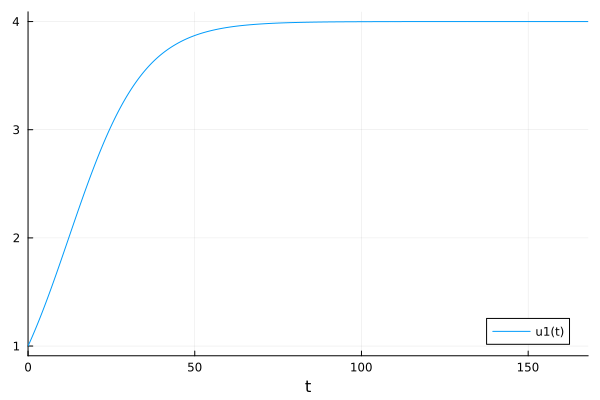

In [13]:
#plot(sol)

In [14]:
cost_function = build_loss_objective(prob, Tsit5(), L2Loss(t, data),
                                     Optimization.AutoForwardDiff(),
                                     maxiters = 10000, verbose = false)

(::OptimizationFunction{true, AutoForwardDiff{nothing, Nothing}, DiffEqParamEstim.var"#29#30"{Nothing, typeof(DiffEqParamEstim.STANDARD_PROB_GENERATOR), Base.Pairs{Symbol, Integer, Tuple{Symbol, Symbol}, NamedTuple{(:maxiters, :verbose), Tuple{Int64, Bool}}}, ODEProblem{Vector{Float64}, Tuple{Float64, Float64}, true, Vector{Float64}, ODEFunction{true, SciMLBase.AutoSpecialize, typeof(singleLogGrowth), LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, NamedTuple{(), Tuple{}}}, SciMLBase.StandardODEProblem}, Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}, L2Loss{Vector{Float64}, Matrix{Float64}, Nothing, Nothing, Nothing}, Nothing, Tuple{}}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Not

In [15]:
optprob = Optimization.OptimizationProblem(cost_function, [0.02, 4.0])
optsol = solve(optprob, BFGS())

retcode: Success
u: 2-element Vector{Float64}:
 0.023136400811637363
 3.0437637034789944

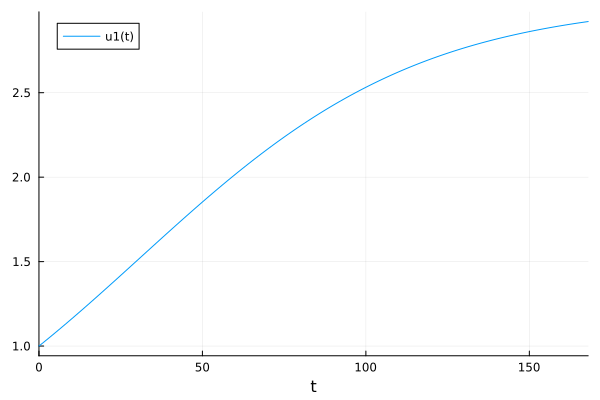

In [16]:
newprob = remake(prob, p = optsol.u)
newsol = solve(newprob, Tsit5(), saveat=1)
#plot(newsol)

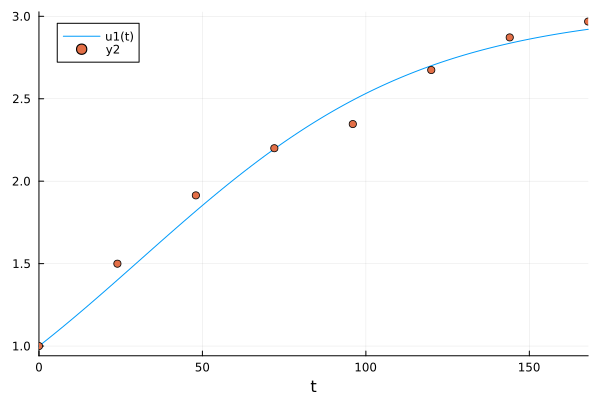

In [17]:
#scatter!(timepts,data_plot)

In [18]:
CSV.write(resultsdirectory,"Predicted_OVCAR3_R_Glu-_50cis_norm.csv",newsol)

"Predicted_OVCAR3_R_Glu-_50cis_norm.csv"